<h2 style="margin:0 0 6px 0; font-weight:500; font-size:18px; line-height:1.25;">
  The transition from rule-based to transformer-based named-entity recognition in information extraction using MultiCoNER II
</h2>

<div style="margin:0; font-size:14px; line-height:1.45;">
  <div style="margin:0 0 2px 0;"><strong>Written Assignment</strong></div>
  <div style="margin:0 0 8px 0;">Advanced NLP and Computer Vision (DLMAIEAIS01)</div>

  <div style="margin:0 0 8px 0;">Applied Artificial Intelligence</div>

  <div style="margin:0 0 2px 0;"><strong>Date:</strong> February 19th, 2026</div>
  <div style="margin:0 0 2px 0;"><strong>Author:</strong> Kai Schiffer</div>
  <div style="margin:0 0 2px 0;"><strong>Matriculation Number:</strong> IU14108163</div>
  <div style="margin:0;"><strong>Tutor’s Name:</strong> Prof. Dr. Tim Schlippe</div>
</div>

In [ ]:
!pip install -U spacy datasets numpy tqdm IProgress ipywidgets pandas matplotlib spaczz "peft==0.11.1" seaborn pytorch-crf "torch==2.5.1" "transformers==4.38.2" accelerate "bitsandbytes==0.49.1"
!pip install -U --no-build-isolation --no-cache-dir "flash-attn==2.8.3"
!pip install ipywidgets==7.7.1

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
# Download the transformer model from HuggingFace

from huggingface_hub import snapshot_download

local_dir = "models/xlm-roberta-large"

snapshot_download(
    repo_id="FacebookAI/xlm-roberta-large",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
)

<div style="margin:0; font-size:14px; line-height:1.55;">
  <p style="margin:0 0 10px 0;">
    In accordance with the written assignment, this section provides the experimental foundation and documents how the research was conducted and recorded.
  </p>

  <p style="margin:0 0 10px 0;">
    We selected spaCy as the primary taxonomy framework because it provides multiple standardized pipelines for experimenting with named-entity recognition (NER) approaches. We begin with rule-based methods—often referred to as <em>gazetteers</em> in the NLP community. Accordingly, we load the MultiCoNER II dataset from the official Hugging Face repository and transform it into a Pandas DataFrame (DF).
  </p>

  <p style="margin:0 0 10px 0;">
    To investigate performance on a coarse-grained task (expected to be substantially easier than a fine-grained task), we apply NER tag filters and map the provided tag IDs to their corresponding coarse classes. These coarse labels are added as an additional column in the DataFrame.
  </p>

  <p style="margin:0;">
    We proceed incrementally: first, an explicit gazetteer lookup baseline; second, a conditional random field (CRF) model; third, a transformer-based approach. Finally, we implement and evaluate a hybrid method to further improve accuracy.
  </p>
</div>

In [3]:
# Standard library
import json
import math
import os
import re
import random
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor

# Third-party
import numpy as np
import torch
import matplotlib.pyplot as plt
import spacy
from IPython.display import display
from spacy.tokens import Doc
from spacy.tokenizer import Tokenizer
from torch.utils.data import DataLoader
from torchcrf import CRF
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model

# Own modules
from data.download import LoadMultiConer
from data.loader import build_token2id, compute_num_tags, VocabEncoder, MultiCoNERDataset, TransformerEncoder, collate_multiconer
from visualization.visualization import update_training_plot

We load MultiCoNER II dataset from their official HuggingFace repo

<span style="font-size:10px; color:#555;">
<strong>Reference</strong><br>
MultiCoNER HF. (n.d.). <em>MultiCoNER dataset on HuggingFace</em>. https://huggingface.co/datasets/MultiCoNER/multiconer_v2
</span>

In [ ]:
prep = LoadMultiConer(
    dest_dir="multiconer2023",
    lang_subdir="EN-English",
)

splits = prep.load_splits()

# Rest is taken from English
ds_train = splits["train"]
ds_val = splits["val"]
ds_test = splits["test"]
ds_test_noisy = splits["test_noisy"]

print(f"Train has {len(ds_train)} samples")
print(f"Validation has {len(ds_val)} samples")
print(f"Test has {len(ds_test)} samples")
print(f"Noisy Test has {len(ds_test_noisy)} samples")

Train has 16778 samples
Validation has 871 samples
Test has 249980 samples
Noisy Test has 74960 samples


In [5]:
print("Some example train sample")
ds_train.head()

Some example train sample


,id,sample_id,tokens,ner_tags,ner_tags_index,domain,corrupt,changed_tokens,changed_indexes,raw_meta
0,0,309f5b26-951e-472b-948e-47632249862b,"[robert, gottschalk, 1939, academy, award, win...","[B-OtherPER, I-OtherPER, O, B-VisualWork, I-Vi...","[51, 52, 0, 9, 10, 0, 0, 0, 0, 37]",en,False,[],[],# id 309f5b26-951e-472b-948e-47632249862b\tdom...
1,1,bb81b9a7-e73d-4977-b6a8-0f7937123dfe,"[during, the, reign, of, the, tongzhi, emperor...","[O, O, O, O, O, B-OtherPER, I-OtherPER, O, O, ...","[0, 0, 0, 0, 0, 51, 52, 0, 0, 0, 0, 0, 0, 0, 0]",en,False,[],[],# id bb81b9a7-e73d-4977-b6a8-0f7937123dfe\tdom...
2,2,d79d2f50-bf45-47c5-96b5-73c3d0ce8914,"[further, research, led, in, the, 1960s, to, t...","[O, O, O, O, O, O, O, O, B-OtherPER, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0,...",en,False,[],[],# id d79d2f50-bf45-47c5-96b5-73c3d0ce8914\tdom...
3,3,6a65789e-e0ff-4263-8bd7-e56b836854c6,"[the, ideas, were, introduced, by, william, bu...","[O, O, O, O, O, B-OtherPER, I-OtherPER, O, O, ...","[0, 0, 0, 0, 0, 51, 52, 0, 0, 0, 0, 0, 0, 0, 0]",en,False,[],[],# id 6a65789e-e0ff-4263-8bd7-e56b836854c6\tdom...
4,4,f3723a6e-426a-4bd3-aa54-41158fab71f2,"[thaddeus, mosley, (, a&s, 1950, ), –, sculpto...","[B-OtherPER, I-OtherPER, O, O, O, O, O, O, O, ...","[51, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",en,False,[],[],# id f3723a6e-426a-4bd3-aa54-41158fab71f2\tdom...


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  MultiCoNER Tagset (Fine → Coarse)
</h2>

<img src="multiconer2_taxonomy_plot.png" alt="MultiCoNER2 Taxonomy" width="450">

<table style="border-collapse:collapse; font-size:12px; line-height:1.25; margin:6px 0 0 0; width:auto;">
  <thead>
    <tr>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Coarse</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd;">Fine labels</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Mapped Coarse BIO IDs</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>O</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">Outside of any entity</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">0 = O</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>LOC</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">Facility · OtherLOC · HumanSettlement · Station</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">1 = B-LOC<br>2 = I-LOC</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>CW</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">VisualWork · MusicalWork · WrittenWork · ArtWork · Software</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">3 = B-CW<br>4 = I-CW</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>GRP</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">MusicalGRP · PublicCORP · PrivateCORP · AerospaceManufacturer · SportsGRP · CarManufacturer · ORG</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">5 = B-GRP<br>6 = I-GRP</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>PER</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">Scientist · Artist · Athlete · Politician · Cleric · SportsManager · OtherPER</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">7 = B-PER<br>8 = I-PER</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>PROD</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">Clothing · Vehicle · Food · Drink · OtherPROD</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">9 = B-PROD<br>10 = I-PROD</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; white-space:nowrap;"><strong>MED</strong></td>
      <td style="padding:3px 6px;">Medication/Vaccine · MedicalProcedure · AnatomicalStructure · Symptom · Disease</td>
      <td style="padding:3px 6px; white-space:nowrap;">11 = B-MED<br>12 = I-MED</td>
    </tr>
  </tbody>
</table>

<span style="font-size:10px; color:#555;">
<strong>Reference</strong><br>
MultiCoNER. (n.d.). <em>MultiCoNER dataset</em>. https://multiconer.github.io/dataset
</span>


In [6]:
# Apply the fine -> coarse mapping as defined before
def coarse_bio_map(idx: int) -> int:
    # 0 stays Outside
    if idx == 0:
        return 0

    if 1 <= idx <= 8:        # LOC
        base = 1   # B-LOC
    elif 9 <= idx <= 20:     # CW
        base = 3   # B-CW
    elif 21 <= idx <= 38:    # GRP
        base = 5   # B-GRP
    elif 39 <= idx <= 52:    # PER
        base = 7   # B-PER
    elif 53 <= idx <= 62:    # PROD
        base = 9   # B-PROD
    elif 63 <= idx <= 72:    # MED
        base = 11  # B-MED
    else:
        raise ValueError(f"Unexpected ner tag idx: {idx} (expected 0..72)")

    # Preserve BIO: fine odd = B, fine even = I
    return base if (idx % 2 == 1) else (base + 1)


def apply_coarse_bio(df, src_col="ner_tags_index", dst_col="coarse_ner_tag_idx"):
    df[dst_col] = df[src_col].apply(lambda seq: [coarse_bio_map(i) for i in seq])
    return df


ds_train = apply_coarse_bio(ds_train)
ds_val   = apply_coarse_bio(ds_val)
ds_test  = apply_coarse_bio(ds_test)
ds_test_noisy  = apply_coarse_bio(ds_test_noisy)

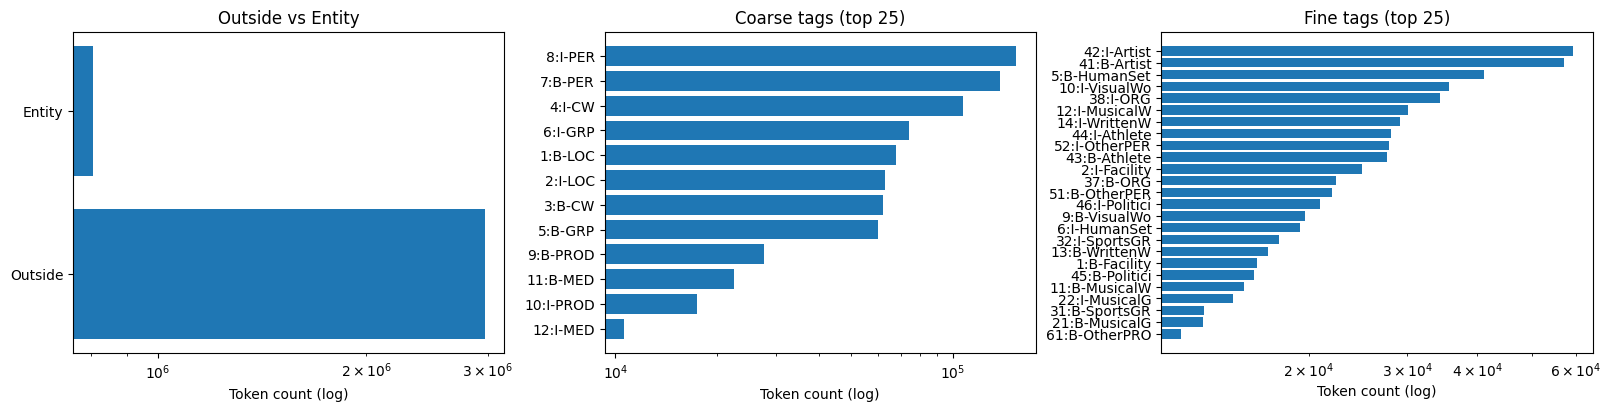

In [7]:
# label sets
fine_labels = LoadMultiConer.NER_TAGS
coarse_labels = [
    "O","B-LOC","I-LOC","B-CW","I-CW","B-GRP","I-GRP","B-PER","I-PER","B-PROD","I-PROD","B-MED","I-MED"
]

TOP_K = 25
LOG_SCALE = True

def topk(flat, labels, top_k=25, drop0=True):
    flat = flat.astype(int)
    counts = np.bincount(flat, minlength=len(labels))
    ids = np.arange(len(labels))
    if drop0:
        ids = ids[1:]
    if top_k is not None:
        ids = ids[np.argsort(counts[ids])][-top_k:]   # keep largest K
    ids = ids[np.argsort(counts[ids])]                # ascending for barh
    names = [f"{i}:{labels[i][:10]}" for i in ids]
    return names, counts[ids]

# flatten sequences
flat_fine   = np.concatenate(ds_test["ner_tags_index"].to_numpy())
flat_coarse = np.concatenate(ds_test["coarse_ner_tag_idx"].to_numpy())

# Outside vs Entity
o_cnt = int((flat_fine == 0).sum())
e_cnt = int(flat_fine.size - o_cnt)

# prep top-k
coarse_names, coarse_cnts = topk(flat_coarse, coarse_labels, TOP_K, drop0=True)
fine_names,   fine_cnts   = topk(flat_fine,   fine_labels,   TOP_K, drop0=True)

# plot
fig, ax = plt.subplots(1, 3, figsize=(16, 4), layout="constrained")

ax[0].barh(["Outside", "Entity"], [o_cnt, e_cnt])
ax[0].set_title("Outside vs Entity")
ax[0].set_xlabel("Token count")

ax[1].barh(coarse_names, coarse_cnts)
ax[1].set_title(f"Coarse tags (top {TOP_K})" if TOP_K else "Coarse tags")
ax[1].set_xlabel("Token count")

ax[2].barh(fine_names, fine_cnts)
ax[2].set_title(f"Fine tags (top {TOP_K})" if TOP_K else "Fine tags")
ax[2].set_xlabel("Token count")

if LOG_SCALE:
    for a in ax:
        a.set_xscale("log")
        a.set_xlabel("Token count (log)")

plt.show()

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Rule-based Gazetteer Tagging (spaCy)
</h2>

<ol style="margin:0 0 6px 18px; padding:0; font-size:13px; line-height:1.25;">
  <li style="margin:0 0 2px 0;">Load a blank English spaCy pipeline.</li>
  <li style="margin:0 0 2px 0;">Build a gazetteer lookup dictionary (optionally including the <code style="font-size:12px;">O</code> tag).</li>
  <li style="margin:0;">Apply BIO tags, for example:</li>
</ol>

<table style="border-collapse:collapse; font-size:12px; line-height:1.25; margin:4px 0 0 0; width:auto;">
  <thead>
    <tr>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Index</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Token</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Tag</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">0</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">by</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">O</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">7</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">sarsen</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">B-PER</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">8</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">amanzholov</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">I-PER</td>
    </tr>
    <tr>
      <td style="padding:3px 6px; white-space:nowrap;">0</td>
      <td style="padding:3px 6px; white-space:nowrap;">and</td>
      <td style="padding:3px 6px; white-space:nowrap;">O</td>
    </tr>
  </tbody>
</table>

<span style="font-size:10px; color:#555;">
  <strong>Reference</strong><br>
  spaCy. (n.d.). <em>Rule-based matching: EntityRuler large phrase patterns</em>. https://spacy.io/usage/rule-based-matching#entityruler-large-phrase-patterns
</span>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We apply the <em>EntityRuler</em>, which can locate both single-token and multi-token patterns. The key intuition is to preserve the BIO scheme by treating matches as token spans (i.e., multi-token entities are represented as contiguous spans rather than independent token labels).
</p>

<table style="border-collapse:collapse; font-size:12px; line-height:1.25; margin:0 0 6px 0; width:auto;">
  <thead>
    <tr>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Pattern type</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd;">Description</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Example</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;"><strong>Phrase</strong></td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">Exact string match (single string pattern)</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">
        <code style="font-size:11px;">{"label": "ORG", "pattern": "Apple"}</code>
      </td>
    </tr>
    <tr>
      <td style="padding:3px 6px; white-space:nowrap;"><strong>Token</strong></td>
      <td style="padding:3px 6px;">Token-level constraints (list of token dictionaries)</td>
      <td style="padding:3px 6px; white-space:nowrap;">
        <code style="font-size:11px;">{"label": "GPE", "pattern": [{"LOWER": "san"}, {"LOWER": "francisco"}]}</code>
      </td>
    </tr>
  </tbody>
</table>

<span style="font-size:10px; color:#555;">
  <strong>Reference</strong><br>
  spaCy. (n.d.). <em>Rule-based matching: EntityRuler patterns</em>. https://spacy.io/usage/rule-based-matching#entityruler-patterns
</span>

In [63]:
# We can run this either for fine- or coarse grain
FINE = True
if FINE:
    tags = ds_train.ner_tags_index
else:
    tags = ds_train.coarse_ner_tag_idx

In [64]:
# Start from scratch, using blank pipeline for performance reasons
nlp = spacy.blank("en")
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r"\S+").match)
ruler = nlp.add_pipe("entity_ruler", config={"phrase_matcher_attr": "LOWER"})

# Choose tag sequences once (avoid name collisions)
tag_seqs = ds_train.ner_tags_index if FINE else ds_train.coarse_ner_tag_idx

# Count how often each phrase appears with each label
phrase_label_counts = defaultdict(Counter)

for tag_seq, toks in zip(tag_seqs, ds_train.tokens):
    i = 0
    while i < len(toks):
        t = tag_seq[i]
        if t != 0 and (t % 2 == 1):
            j = i + 1
            while j < len(toks) and tag_seq[j] == t + 1:
                j += 1
            phrase = " ".join(toks[i:j])
            phrase_label_counts[phrase][str(t)] += 1
            i = j
        else:
            i += 1

# Build patterns by selecting the majority label for each phrase
# Drop phrases that are too ambiguous
def entropy(counter):
    total = sum(counter.values())
    ps = [c/total for c in counter.values()]
    return -sum(p * math.log10(p) for p in ps if p > 0)/math.log10(len(counter))

H_THRESHOLD = 0.92  # H_MAX := 1 (by definiton)
MATCH_MODE = "exact"

patterns = []
for phrase, cnt in phrase_label_counts.items():
    if len(cnt) > 1:
        H = entropy(cnt)
    else:
        H = 0
    lbl, top = cnt.most_common(1)[0]
    if H <= H_THRESHOLD:
        if MATCH_MODE == "exact":
            patterns.append({"label": lbl, "pattern": phrase})
        elif MATCH_MODE == "fuzzy1":
            patterns.append({"label": lbl, "pattern": [{"LOWER": {"FUZZY1": t}} for t in phrase.split()]})

ruler.add_patterns(patterns)
print(f"Added {len(patterns):,} patterns after majority-vote + ambiguity filter")

Added 20,354 patterns after majority-vote + ambiguity filter


<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  For evaluation, we follow the protocol described in the SemEval-2023 Task 2 (MultiCoNER II) paper. The shared task ranks systems using macro-averaged F1 under an exact-match criterion, i.e., both entity boundary and entity type must match the gold annotation. As stated in the paper: &ldquo;F1 scores are computed over the fine-grained types using exact matching &hellip; and averaged across all types.&rdquo;
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  To align our outputs with this evaluation, we convert token-level BIO tag sequences (encoded as integers with <code style="font-size:12px;">0 = O</code>, odd = <code style="font-size:12px;">B-*</code>, even = <code style="font-size:12px;">I-*</code>) into entity spans using <code style="font-size:12px;">bio_to_spans(tags)</code>. This function scans the sequence, identifies each <code style="font-size:12px;">B-*</code> label, and extends it over consecutive matching <code style="font-size:12px;">I-*</code> labels. It returns span tuples of the form <span style="color:#555;">(start, end, label_id)</span>, where <span style="color:#555;">start</span> is inclusive and <span style="color:#555;">end</span> is exclusive.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  For each sentence, we compute true positives, false positives, and false negatives via set operations on predicted and gold span sets. Precision, recall, and F1 are then calculated per class using <code style="font-size:12px;">count_per_class_scores</code>. Only valid <code style="font-size:12px;">B-*</code> labels (odd indices) are considered as entity classes. Macro precision, macro recall, and macro F1 are obtained by averaging over all active span classes.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  To quantify statistical variability, we perform bootstrap resampling using <code style="font-size:12px;">bootstrap_sampling</code>. We repeatedly sample sentence-level (gold, prediction) pairs with replacement and recompute macro metrics. From the resulting empirical distributions, we estimate the mean, variance, and 95% confidence intervals using <code style="font-size:12px;">get_bootstrap_metrics</code>.
</p>

<table style="border-collapse:collapse; font-size:12px; line-height:1.25; margin:0; width:auto;">
  <thead>
    <tr>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd; white-space:nowrap;">Step</th>
      <th style="text-align:left; padding:3px 6px; border-bottom:1px solid #ddd;">Operation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">1</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">
        Convert BIO tag sequences to span sets via <code style="font-size:11px;">bio_to_spans(tags)</code>.
      </td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">2</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">
        Compute TP/FP/FN per class using exact span matching.
      </td>
    </tr>
    <tr>
      <td style="padding:3px 6px; border-bottom:1px solid #eee; white-space:nowrap;">3</td>
      <td style="padding:3px 6px; border-bottom:1px solid #eee;">
        Derive per-class precision/recall/F1 and macro-average across classes.
      </td>
    </tr>
    <tr>
      <td style="padding:3px 6px; white-space:nowrap;">4</td>
      <td style="padding:3px 6px;">
        Estimate mean, variance, and 95% confidence intervals via bootstrap resampling.
      </td>
    </tr>
  </tbody>
</table>

<span style="font-size:10px; color:#555;">
  <strong>Reference</strong><br>
  SemEval-2023 Task 2. (2023). <em>MultiCoNER II: Fine-grained multilingual named entity recognition</em>. https://aclanthology.org/2023.semeval-1.310.pdf
</span>


In [69]:
def get_all_ner_tags(ner_idx):
    return set(ner_idx.explode().tolist())

def get_active_span_classes(gold_seqs, pred_seqs):
    classes = set()
    for g, p in zip(gold_seqs, pred_seqs):
        classes.update(lbl for _, _, lbl in bio_to_spans(g))
        classes.update(lbl for _, _, lbl in bio_to_spans(p))
    return classes

def bio_to_spans(tags):
    # We encode a sequence to indicate when a entitiy starts with B-
    # that is (start idx, end idx, B-label)
    # tags are ints: 0=O, odd=B-*, even=I-*
    spans = []
    i = 0
    while i < len(tags):
        t = tags[i]
        if t == 0 or (t % 2 == 0):
            i += 1
            continue
        j = i + 1
        while j < len(tags) and tags[j] == t + 1:
            j += 1
        spans.append((i, j, t))   # (start, end, B-label)
        i = j
    return set(spans)

GP = None
N = None
CLASSES = None

def init_worker(gp, n, classes):
    global GP, N, CLASSES
    GP, N, CLASSES = gp, n, classes

def bootstrap_once(i):
    rnd = random.Random(1337 + i)
    res = rnd.choices(GP, k=N)
    rg = [e[0] for e in res]
    rp = [e[1] for e in res]
    _, macro_f1, _, _, macro_prec, macro_recall = count_per_class_scores(rg, rp, CLASSES)
    return macro_f1, macro_prec, macro_recall

def bootstrap_sampling(gold_seqs, pred_seqs, classes, B):
    macro_f1_distr, macro_prec_distr, macro_recall_distr = [], [], []
    gp = list(zip(gold_seqs, pred_seqs))
    n = len(gp)

    with ProcessPoolExecutor(max_workers=10, initializer=init_worker, initargs=(gp, n, classes)) as ex:
        it = ex.map(bootstrap_once, range(B))
        for f1, p, r in tqdm(it, total=B):
            macro_f1_distr.append(f1)
            macro_prec_distr.append(p)
            macro_recall_distr.append(r)

    return macro_f1_distr, macro_prec_distr, macro_recall_distr

def get_bootstrap_metrics(macro_f1_distr, macro_prec_distr, macro_recall_distr):
    x_f1 = np.asarray(macro_f1_distr, dtype=float)
    x_p = np.asarray(macro_prec_distr, dtype=float)
    x_r = np.asarray(macro_recall_distr, dtype=float)
    X = [x_f1, x_p, x_r]

    mean = []
    var = []
    ci_low = []
    ci_high = []
    for x in X:
        mean.append(x.mean())
        var.append(x.var(ddof=1))
        ci_low.append(np.quantile(x, [0.025, 0.975])[0])
        ci_high.append(np.quantile(x, [0.025, 0.975])[1])

    return mean, var, ci_low, ci_high

def plt_stats(mean, var, ci_low, ci_high):
    cname = ["Macro F1", "Macro P ", "Macro R "]
    for m, v, cl, ch, cn in zip(mean, var, ci_low, ci_high, cname):
        sd = math.sqrt(v)
        print(f"{cn} = {m:.3f} ± {sd:.4f}; 95%-CI ({cl:.3f}, {ch:.3f})")

def count_per_class_scores(gold_seqs, pred_seqs, classes):
    # available_ids = set([f for e in gold_seqs + pred_seqs for f in e])
    available_ids = classes
    cc_cnt = {c:(0,0,0) for c in available_ids if c%2} # TP | FP | FN
    per_class_f1 = {c:0 for c in available_ids if c%2}
    per_class_prec = {c:0 for c in available_ids if c%2}
    per_class_recall = {c:0 for c in available_ids if c%2}
    for gold, pred in zip(gold_seqs, pred_seqs):
        g = bio_to_spans(gold)
        p = bio_to_spans(pred)
        # Store all markers
        tp = g & p
        fp = p - g
        fn = g - p
        for e in tp:
            idx = e[2]
            if idx not in cc_cnt:
                continue
            cc_cnt[idx] = (cc_cnt[idx][0] + 1,cc_cnt[idx][1],cc_cnt[idx][2])
        for e in fp:
            idx = e[2]
            if idx not in cc_cnt:
                continue
            cc_cnt[idx] = (cc_cnt[idx][0],cc_cnt[idx][1] + 1,cc_cnt[idx][2])
        for e in fn:
            idx = e[2]
            if idx not in cc_cnt:
                continue
            cc_cnt[idx] = (cc_cnt[idx][0],cc_cnt[idx][1],cc_cnt[idx][2] + 1)
    for key, tpl in zip(cc_cnt.keys(),cc_cnt.values()):
        if tpl[0] > 0:
            per_class_prec[key] = tpl[0] / (tpl[0] + tpl[1])
            per_class_recall[key] = tpl[0] / (tpl[0] + tpl[2])
            per_class_f1[key] = (2*per_class_prec[key]*per_class_recall[key])/(per_class_prec[key]+per_class_recall[key])
        else:
            per_class_prec[key] = 0
            per_class_recall[key] = 0
            per_class_f1[key] = 0

    macro_f1 = sum(per_class_f1.values())/len(per_class_f1)
    macro_prec = sum(per_class_prec.values())/len(per_class_prec)
    macro_recall = sum(per_class_recall.values())/len(per_class_recall)
    return per_class_f1, macro_f1, per_class_prec, per_class_recall, macro_prec, macro_recall

In [66]:
def predict_bio(tokens):
    # We build the documents from the word tokens given in the dataset
    spaces = [True] * len(tokens)
    spaces[-1] = False

    # Run actual Gazetteers look-up using nlp
    doc = Doc(nlp.vocab, words=tokens, spaces=spaces)
    doc = nlp(doc)

    tags = [0] * len(doc)
    for ent in doc.ents:
        b = int(ent.label_)
        for k, tok in enumerate(ent):
            tags[tok.i] = b if k == 0 else (b + 1)   # I-tag is b+1
    return tags

In [14]:
# Run prediction on test set
pred_seqs = [predict_bio(toks) for toks in tqdm(ds_test.tokens)]

if FINE:
    gold_seqs = ds_test.ner_tags_index.tolist()
else:
    gold_seqs = ds_test.coarse_ner_tag_idx.tolist()

# Only evaluate active classes 
classes = get_active_span_classes(gold_seqs, pred_seqs)

# Create bootstrap random variables with B samples
macro_f1_distr, macro_prec_distr, macro_recall_distr = bootstrap_sampling(gold_seqs, pred_seqs, classes, B=1000)

# Estimate stats using random variables
mean, var, ci_low, ci_high = get_bootstrap_metrics(macro_f1_distr, macro_prec_distr, macro_recall_distr)

# Plot stats formatted
plt_stats(mean, var, ci_low, ci_high)

Macro F1 = 0.266 ± 0.0012; 95%-CI (0.263, 0.268)
Macro P  = 0.353 ± 0.0016; 95%-CI (0.350, 0.356)
Macro R  = 0.247 ± 0.0012; 95%-CI (0.245, 0.250)


In [17]:
# Run prediction on noisy test set
pred_seqs = [predict_bio(toks) for toks in tqdm(ds_test_noisy.tokens)]

if FINE:
    gold_seqs = ds_test_noisy.ner_tags_index.tolist()
else:
    gold_seqs = ds_test_noisy.coarse_ner_tag_idx.tolist()

# Only evaluate active classes 
classes = get_active_span_classes(gold_seqs, pred_seqs)

# Create bootstrap random variables with B samples
macro_f1_distr, macro_prec_distr, macro_recall_distr = bootstrap_sampling(gold_seqs, pred_seqs, classes, B=1000)

# Estimate stats using random variables
mean, var, ci_low, ci_high = get_bootstrap_metrics(macro_f1_distr, macro_prec_distr, macro_recall_distr)

# Plot stats formatted
plt_stats(mean, var, ci_low, ci_high)

Macro F1 = 0.116 ± 0.0018; 95%-CI (0.113, 0.120)
Macro P  = 0.204 ± 0.0031; 95%-CI (0.197, 0.210)
Macro R  = 0.096 ± 0.0016; 95%-CI (0.092, 0.099)


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Conditional Random Fields
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We pre-evaluate the maximum sequence length. For the CRF, this is <code style="font-size:12px;">MAX_WORDS</code>, and for the Transformer, it is <code style="font-size:12px;">MAX_SUBWORDS</code>. What are the actual truncation, padding, and out-of-vocabulary (OOV) rates for each dataset split if we apply only tokens from the training set?
</p>

In [71]:
FINE = True

MAX_WORDS    = 30
MAX_SUBWORDS = 80

PAD_TAG = compute_num_tags(ds_train, FINE) - 1

tokenizer = AutoTokenizer.from_pretrained("models/xlm-roberta-large", use_fast=True)
vocab = VocabEncoder(build_token2id(ds_train))
tfm   = TransformerEncoder(tokenizer)

PAD_ID, UNK_ID = vocab.pad_id, vocab.unk_id
UNK_ID_T = tokenizer.unk_token_id

def crf_rates(df):
    ds = MultiCoNERDataset(df, MAX_WORDS, FINE, PAD_TAG, vocab, "crf")
    dl = DataLoader(ds, batch_size=64, shuffle=False, collate_fn=collate_multiconer)

    oov = pad = tr = tot = 0
    pos = torch.arange(MAX_WORDS)

    for seqs, _, _, words in dl:
        lens_raw = torch.tensor([len(w) for w in words], dtype=torch.long)
        lens = torch.clamp(lens_raw, max=MAX_WORDS)

        valid = pos.unsqueeze(0) < lens.unsqueeze(1) 
        oov += ((seqs == UNK_ID) & valid).sum().item()
        pad += (seqs == PAD_ID).sum().item()
        tr += (lens_raw > MAX_WORDS).sum().item()
        tot += lens.sum().item()

    n = len(ds)
    return (
        100 * oov / tot if tot else 0.0,
        100 * pad / (n * MAX_WORDS) if n else 0.0,
        100 * tr / n if n else 0.0,
    )

def tfm_rates(df):
    ds = MultiCoNERDataset(df, MAX_SUBWORDS, FINE, PAD_TAG, tfm, "tfm_crf", MAX_WORDS)
    dl = DataLoader(ds, batch_size=64, shuffle=False, collate_fn=collate_multiconer)

    unk = pad = sub_tr = real = 0

    for ids, attn, wids, _, _, words in dl:
        pad  += (attn == 0).sum().item()
        real += (attn == 1).sum().item()
        unk  += ((attn == 1) & (ids == UNK_ID_T)).sum().item()

        last_wid = torch.where(wids >= 0, wids, torch.full_like(wids, -1)).max(dim=1).values
        word_len = torch.tensor([len(ws) for ws in words], dtype=torch.long)  # already capped at MAX_WORDS
        sub_tr += ((last_wid >= 0) & (last_wid < (word_len - 1))).sum().item()

    n = len(ds)
    word_tr = sum(len(toks) > MAX_WORDS for toks in df.tokens)
    return (
        100 * unk / real if real else float("nan"),
        100 * pad / (n * MAX_SUBWORDS) if n else 0.0,
        100 * sub_tr / n if n else 0.0,
        100 * word_tr / n if n else 0.0,
    )

print(f"NOTE: rates depend on MAX_WORDS={MAX_WORDS} and MAX_SUBWORDS={MAX_SUBWORDS}\n")

for name, df in [("train", ds_train), ("test", ds_test), ("val", ds_val), ("noise", ds_test_noisy)]:
    oov_w, pad_w, tr_w = crf_rates(df)
    unk_t, pad_t, sub_tr_t, word_tr_t = tfm_rates(df)

    print(f"[{name}] WORD/CRF   OOV={oov_w:.2f}%  PAD={pad_w:.2f}%  TRUNC(word)={tr_w:.2f}%")
    print(
        f"[{name}] TFM        UNK={('n/a' if unk_t != unk_t else f'{unk_t:.2f}%')}  "
        f"PAD={pad_t:.2f}%  TRUNC(subword)={sub_tr_t:.2f}%  TRUNC(word_cap)={word_tr_t:.2f}%\n"
    )

NOTE: rates depend on MAX_WORDS=30 and MAX_SUBWORDS=80

[train] WORD/CRF   OOV=0.00%  PAD=49.76%  TRUNC(word)=0.26%
[train] TFM        UNK=0.00%  PAD=70.89%  TRUNC(subword)=0.00%  TRUNC(word_cap)=0.26%

[test] WORD/CRF   OOV=10.69%  PAD=49.70%  TRUNC(word)=0.26%
[test] TFM        UNK=0.00%  PAD=70.54%  TRUNC(subword)=0.00%  TRUNC(word_cap)=0.26%

[val] WORD/CRF   OOV=8.36%  PAD=49.05%  TRUNC(word)=0.57%
[val] TFM        UNK=0.00%  PAD=70.60%  TRUNC(subword)=0.00%  TRUNC(word_cap)=0.57%

[noise] WORD/CRF   OOV=15.75%  PAD=49.74%  TRUNC(word)=0.25%
[noise] TFM        UNK=0.00%  PAD=69.61%  TRUNC(subword)=0.00%  TRUNC(word_cap)=0.25%



<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;"> As shown, the truncation rate is very low (&lt;1%), which preserves most of the information. With the CRF tokenizer, the maximum OOV rate is 15.75% when using the noisy set, meaning these tokens are replaced by an <code style="font-size:12px;">UNK</code> representation in the embedding layer. Lastly, we observe moderate padding rates, which reflect a trade-off between computational overhead and information loss. </p> <p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;"> Our primary objective is to minimize information loss (i.e., the truncation rate). In this setting, applying static padding across the entire dataset increases computational waste. </p>

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Linear Chain CRF Model
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We define a neural CRF, <code style="font-size:12px;">LinearChainCRF</code>, based on a PyTorch CRF layer, and use an embedding layer to produce a neural emission-score representation. We then project the resulting latent outputs back onto the tag-sequence dimension via a linear layer.
</p>

In [ ]:
class LinearChainCRF(torch.nn.Module):
    def __init__(self, num_tags, vocab_size, d_model, pad_idx, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # LinearChainCRF input expects (seq_length, batch_size, num_tags)
        self.crf_model = CRF(num_tags)
        self.emissions = torch.nn.Sequential(
            torch.nn.Embedding(vocab_size, d_model, padding_idx=pad_idx),
            torch.nn.Linear(d_model, num_tags)
            )
        
    def forward(self, x, tags, mask):
        # tags is expected as: (seq_length, batch_size)
        # returns the neg-log-likelihood
        # embedding = self.embedding(x)
        # linear = self.linear(embedding).permute(1,0,2)

        # Estimate the emission scores
        emission_scores = self.emissions(x).permute(1,0,2)

        # The crf_model method returns the loss (pos-log-likelihood)
        # as a sum over all tokens.
        # We therefore calculate the mean loss per token (token_mean).
        # This makes the loss observation interpretable.
        neg_log_ll = -self.crf_model(emission_scores, tags.T, mask.T, reduction='token_mean')
        
        return neg_log_ll
    
    def decode(self, x, mask):
        # Estimate the emission scores
        emission_scores = self.emissions(x).permute(1,0,2)

        # Run Viterbi to get the maximum a posterior (MAP) 
        # = most likely label per token
        # argmax_y P(y_pred | x)
        return self.crf_model.decode(emission_scores, mask.T)

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  CRF Encoding Sanity Check
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We perform a quick sanity check to ensure that our CRF tokenizer is functioning correctly.
</p>

In [40]:
#####################################
# JUST FOR DEMONSTARTION AND ANALYSIS
#####################################

BATCH_SIZE = 1

vocab_encoder = VocabEncoder(token2id=build_token2id(ds_train))

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}

MAX_WORDS = 20
FINE = True
DEMO_PAD_TAG = compute_num_tags(ds_train, FINE) - 1

val_loader = DataLoader(
    MultiCoNERDataset(ds_val, MAX_WORDS, FINE, DEMO_PAD_TAG, vocab_encoder, "crf"),
    shuffle=False,
    **loader_args,
)

encoded_sequence = list(val_loader)[0]
seq_t, tag_t, mask_t, words = encoded_sequence

# Reverse keys/values for id2token lookup
id2token = {v: k for k, v in build_token2id(ds_train).items()}


# Show the original input sequence from validation data
print(f"Original sequence from validation data\n{words[0]}\n")

# Is resulting length MAX_WORDS?
print(f"Sequence was encoded, is the requested length (MAX_WORDS={MAX_WORDS}) compliant?\n{MAX_WORDS == len([id2token[int(e)] for e in seq_t[0]])}\n")

# Show the decoded token sequence
print(f"Encoded sequence decoded back (whats UNK or PAD?):\n{[id2token[int(e)] for e in seq_t[0]]}\n")

# Show that all the tags were padded accordingly to MAX_WORDS using DEMO_PAD_TAG
print(f"Show the {len(tag_t[0].tolist())} GT tags:\n{tag_t[0].tolist()}\n")

# Show that mask is applied True to all real tokens, PAD is set to False and wont trained
print(f"Only real tokens should be trained, rest is False in mask:\n{mask_t[0].tolist()}")

# Findings
# CRF only case:
# -> Tags are padded correctly with a dedicated pad-tag id (different from O=0).
# -> This avoids removing true O labels when filtering pad positions during evaluation.

Original sequence from validation data
['eli', 'lilly', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'lilly', 'and', 'company']

Sequence was encoded, is the requested length (MAX_WORDS=20) compliant?
True

Encoded sequence decoded back (whats UNK or PAD?):
['eli', 'UNK', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'UNK', 'and', 'company', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']

Show the 20 GT tags:
[51, 52, 0, 0, 0, 0, 0, 23, 24, 24, 24, 73, 73, 73, 73, 73, 73, 73, 73, 73]

Only real tokens should be trained, rest is False in mask:
[True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False]


<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  In the example above, we start with a word-level token sequence from the dataset:
  <code style="font-size:12px;">['eli', 'lilly', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'lilly', 'and', 'company']</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  When encoding this sequence using our CRF tokenizer <code style="font-size:12px;">VocabEncoder.encode_tokens()</code> (baked into the <code style="font-size:12px;">MultiCoNERDataset</code> class), we check whether the encoded sequence length is compliant with <code style="font-size:12px;">MAX_WORDS = 20</code>. If fewer than 20 tokens occur, we pad with <code style="font-size:12px;">PAD</code> tokens; otherwise, we truncate.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  If we then decode the sequence back using the inverted index <code style="font-size:12px;">id2token</code>, we observe what the model input actually sees:
  <code style="font-size:12px;">['eli', 'UNK', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'UNK', 'and', 'company', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']</code>.
  As shown, we fill up the sequence using 9 <code style="font-size:12px;">PAD</code> tokens. Furthermore, 2 tokens (both occurrences of <code style="font-size:12px;">'lilly'</code>) are not seen in the training data and are therefore mapped to <code style="font-size:12px;">UNK</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We then must ensure that the label sequence has the same length:
  <code style="font-size:12px;">[51, 52, 0, 0, 0, 0, 0, 23, 24, 24, 24, 73, 73, 73, 73, 73, 73, 73, 73, 73]</code>.
  We use <code style="font-size:12px;">73</code> as a dedicated padding tag ID for positions not occupied by real dataset label ids.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Finally, we build the mask used by the CRF and emission layer. Since we do not want parameter updates on padding positions, we set those to <code style="font-size:12px;">False</code> and all real-token positions to <code style="font-size:12px;">True</code>:
  <code style="font-size:12px;">[True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False]</code>.
</p>


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Neural CRF Training and Checkpointing
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We train the neural CRF (<code style="font-size:12px;">LinearChainCRF</code>) with <code style="font-size:12px;">MAX_WORDS=30</code> and fine-grained labels (<code style="font-size:12px;">FINE=True</code>) using batches of size <code style="font-size:12px;">64</code> for <code style="font-size:12px;">50</code> epochs with Adam (<code style="font-size:12px;">LR=1e-3</code>). The vocabulary <code style="font-size:12px;">token2id</code> is built only from the training split, and the last tag ID is reserved as <code style="font-size:12px;">PAD_TAG</code>. The model uses an emission dimension of <code style="font-size:12px;">D_MODEL=256</code> and is trained with a padding mask to ignore <code style="font-size:12px;">PAD</code> positions.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  After each epoch, we decode the validation set via <code style="font-size:12px;">model.decode(seq, mask)</code>, truncate sequences to the effective length derived from the mask, drop <code style="font-size:12px;">PAD_TAG</code>, and compute validation macro-F1 using active span classes. We log epoch metrics to <code style="font-size:12px;">models/neural_crf/crf_training_metrics.jsonl</code>, update a live training plot, and checkpoint the best-performing model (highest validation macro-F1) to <code style="font-size:12px;">models/neural_crf/model_epoch_&lt;epoch&gt;.pt</code>.
</p>

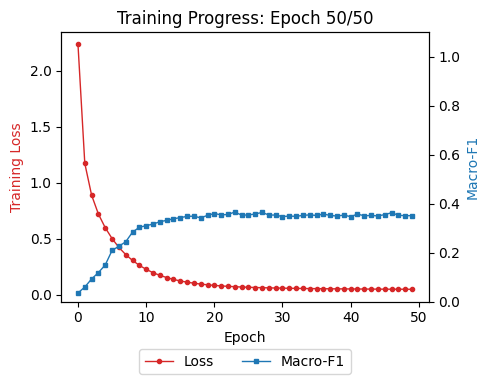

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
MAX_WORDS = 30
FINE = True
D_MODEL = 256

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data Preparation
num_tags = compute_num_tags(ds_train, FINE)
PAD_TAG = num_tags - 1
token2id = build_token2id(ds_train)
vocab_encoder = VocabEncoder(token2id=token2id)

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}
train_loader = DataLoader(
    MultiCoNERDataset(ds_train, MAX_WORDS, FINE, PAD_TAG, vocab_encoder, "crf"),
    shuffle=True,
    **loader_args,
)
val_loader = DataLoader(
    MultiCoNERDataset(ds_val, MAX_WORDS, FINE, PAD_TAG, vocab_encoder, "crf"),
    shuffle=False,
    **loader_args,
)

# Model Initialization
model = LinearChainCRF(
    num_tags=num_tags, 
    vocab_size=len(token2id), 
    pad_idx=token2id['PAD'], 
    d_model=D_MODEL).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training Loop
train_losses, val_f1s = [], []
plot_handle = display(None, display_id=True)

# We store the best models to disk
old_f1 = 0
save_dir = "models/neural_crf"
METRICS_PATH = f"{save_dir}/crf_training_metrics.jsonl"
os.makedirs(save_dir, exist_ok=True)
best_model = 0

with open(METRICS_PATH, "w") as fjsonl:
    epoch_pbar = tqdm(range(EPOCHS), desc="Epoch", position=0)
    for epoch in epoch_pbar:
        # TRAIN
        model.train()
        total_loss = 0.0

        pbar = tqdm(
            train_loader,
            desc=f"Train {epoch + 1}/{EPOCHS}",
            leave=False,
            position=1,
        )

        for seq, tags, mask, _ in pbar:
            seq, tags, mask = seq.to(DEVICE), tags.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            loss = model(seq, tags, mask)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # EVAL
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
            for seq, tags, mask, _ in val_loader:
                preds = model.decode(seq.to(DEVICE), mask.to(DEVICE))
                for g, p, mk in zip(tags.tolist(), preds, mask.tolist()):
                    L = int(sum(mk))
                    gold_all.append([x for x in g[:L] if x != PAD_TAG])
                    pred_all.append([x for x in p[:L] if x != PAD_TAG])

        classes = get_active_span_classes(gold_all, pred_all)
        _, macro_f1, *_ = count_per_class_scores(gold_all, pred_all, classes)
        val_f1s.append(float(macro_f1))

        if old_f1 < macro_f1:
            old_f1 = macro_f1
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            best_model = f"model_epoch_{epoch}.pt"


        # VISUALIZE & LOG
        update_training_plot(
            train_losses, val_f1s, epoch, EPOCHS,
            plot_handle
        )

        metrics = {"epoch": epoch, "loss": avg_loss, "f1": float(macro_f1)}
        fjsonl.write(json.dumps(metrics) + "\n")
        fjsonl.flush()

        epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}", f1=f"{float(macro_f1):.4f}")

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Test Evaluation
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We construct a non-shuffled <code style="font-size:12px;">test_loader</code> over <code style="font-size:12px;">ds_test</code> using the same <code style="font-size:12px;">MultiCoNERDataset</code> configuration (<code style="font-size:12px;">MAX_WORDS</code>, <code style="font-size:12px;">FINE</code>, <code style="font-size:12px;">PAD_TAG</code>, and the training-derived <code style="font-size:12px;">vocab_encoder</code>). In evaluation mode, we decode tag sequences via <code style="font-size:12px;">model.decode(seq, mask)</code>, truncate each sequence to its effective length <code style="font-size:12px;">L</code> (from the mask), and remove padding labels before collecting gold and predicted tag sequences.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We then evaluate using exact-match span scoring: we restrict scoring to the active span classes observed in either gold or predictions and estimate macro precision, macro recall, and macro F1 via bootstrap resampling. Specifically, we draw <code style="font-size:12px;">B=1000</code> bootstrap samples of sentence-level (gold, prediction) pairs with replacement, compute macro metrics for each sample, and report the mean, variance, and 95% confidence intervals using <code style="font-size:12px;">get_bootstrap_metrics</code> and <code style="font-size:12px;">plt_stats</code>.
</p>

In [ ]:
def test_model(model, df, BATCH_SIZE, mdl_variant, encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, fine_labels_enbl):
    # Load the test data
    loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}

    if mdl_variant == "crf":
        test_loader = DataLoader(
            MultiCoNERDataset(
                df,
                max_seq_len=MAX_WORDS,
                fine_labels_enbl=fine_labels_enbl,
                pad_tag=PAD_TAG,
                encoder=encoder,
                output_format=mdl_variant,
            ),
            shuffle=False,
            **loader_args,
        )

        # TEST
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
            for seq, tags, mask, _ in tqdm(test_loader):
                preds = model.decode(seq.to(DEVICE), mask.to(DEVICE))
                for g, p, mk in zip(tags.tolist(), preds, mask.tolist()):
                    L = int(sum(mk))
                    gold_all.append([x for x in g[:L] if x != PAD_TAG])
                    pred_all.append([x for x in p[:L] if x != PAD_TAG])

    elif mdl_variant == "tfm_crf":
        test_loader = DataLoader(
            MultiCoNERDataset(
                df,
                max_seq_len=MAX_SUBWORDS,
                fine_labels_enbl=fine_labels_enbl,
                pad_tag=PAD_TAG,
                encoder=encoder,
                output_format="tfm_crf",
                max_word_len=MAX_WORDS,
            ),
            shuffle=False,
            **loader_args,
        )

        # TEST
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
          for input_ids, attn, wids, tags, mask, _ in tqdm(test_loader):
            input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
            attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
            wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
            mask_t    = mask.to(DEVICE, non_blocking=PIN_MEMORY)

            pred_batch = model.decode(input_ids, attn, wids, mask_t)
            tags_batch = tags.tolist()
            mask_batch = mask.tolist()

            for g, p, mk in zip(tags_batch, pred_batch, mask_batch):
                L = int(sum(mk))
                g = g[:L]
                p = p[:L]
                g = [x for x in g if x != PAD_TAG]
                p = [x for x in p if x != PAD_TAG]
                gold_all.append(g)
                pred_all.append(p)

    # EVALUATE

    # Get only active classes
    classes = get_active_span_classes(gold_all, pred_all)

    # Create bootstrap random variables with B samples
    macro_f1_distr, macro_prec_distr, macro_recall_distr = bootstrap_sampling(gold_all, pred_all, classes, B=1000)

    # Estimate stats using random variables
    mean, var, ci_low, ci_high = get_bootstrap_metrics(macro_f1_distr, macro_prec_distr, macro_recall_distr)

    # Plot stats formatted
    plt_stats(mean, var, ci_low, ci_high)

In [ ]:
# Execute test for clean test set using the best model
model.load_state_dict(torch.load(os.path.join(save_dir, best_model), weights_only=True))
test_model(model, ds_test, BATCH_SIZE, "crf", vocab_encoder, MAX_WORDS, 0, PAD_TAG, FINE)

Macro F1 = 0.294 ± 0.0012; 95%-CI (0.291, 0.296)
Macro P  = 0.394 ± 0.0016; 95%-CI (0.390, 0.396)
Macro R  = 0.262 ± 0.0012; 95%-CI (0.260, 0.264)


In [ ]:
# Execute test for noisy test set
test_model(model, ds_test_noisy, BATCH_SIZE, "crf", vocab_encoder, MAX_WORDS, 0, PAD_TAG, FINE)

Macro F1 = 0.158 ± 0.0020; 95%-CI (0.154, 0.162)
Macro P  = 0.257 ± 0.0032; 95%-CI (0.250, 0.263)
Macro R  = 0.140 ± 0.0017; 95%-CI (0.136, 0.143)


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  XLM-R + CRF neural NER
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We implement <code style="font-size:12px;">XLMCRF</code> as a Transformer-CRF tagger that uses a pretrained encoder to produce subword embeddings, pools them to word-level representations, and performs structured decoding with a linear-chain CRF. The padding label is fixed to <code style="font-size:12px;">pad_tag_id = num_tags - 1</code>, and the Transformer pooler is disabled so that only the last hidden state is used.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Given <code style="font-size:12px;">input_ids</code> and <code style="font-size:12px;">attention_mask</code>, the model extracts the last hidden state <code style="font-size:12px;">H_sub</code> and aligns subwords to words via mean pooling using <code style="font-size:12px;">word_ids</code> (with <code style="font-size:12px;">-1</code> for special tokens). This yields a fixed-size word tensor <code style="font-size:12px;">H_word</code> of shape <code style="font-size:12px;">(B, MAX_WORDS, H)</code>, aligned to <code style="font-size:12px;">MAX_WORDS</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Emission scores are computed by a linear projection from the Transformer hidden size to <code style="font-size:12px;">num_tags</code> and permuted to the CRF layout <code style="font-size:12px;">(W, B, num_tags)</code>. To prevent assigning the padding tag to real word positions, the PAD column is masked to a large negative value (<code style="font-size:12px;">-1e4</code>) wherever <code style="font-size:12px;">mask</code> is <code style="font-size:12px;">True</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  During training, <code style="font-size:12px;">forward</code> returns the negative log-likelihood <code style="font-size:12px;">-CRF(emissions, tags, mask)</code> with <code style="font-size:12px;">token_mean</code> reduction. At inference time, <code style="font-size:12px;">decode</code> runs Viterbi decoding over the same masked emissions to produce the best tag sequence per input.
</p>

In [ ]:
class XLMCRF(torch.nn.Module):
    def __init__(self, num_tags, max_words, device, model_path):
        super().__init__()
        self.max_words = max_words
        self.device = device
        self.pad_tag_id = num_tags - 1  # PAD_TAG

        self.transformer = AutoModel.from_pretrained(
            pretrained_model_name_or_path=model_path,
            torch_dtype=torch.float32,
        ).to(device)

        # We only consider the last hidden state after encoder output
        # Hence, model internal pooler is dropped
        if hasattr(self.transformer, "pooler"):
            self.transformer.pooler = None

        # Expect as d_model = hidden_size of 1024 what is applied to linear projection
        self.hidden_size = self.transformer.config.hidden_size
        self.linear_projection = torch.nn.Linear(self.hidden_size, num_tags).to(device)
        self.crf = CRF(num_tags).to(device)

    def alignment_mean_pool(self, H_sub, word_ids):
        # H_sub: (B, S, H), word_ids: (B, S) with -1 for specials
        B, S, H = H_sub.shape
        out = H_sub.new_zeros(B, self.max_words, H)

        for b in range(B):
            w = word_ids[b]
            m = w.ge(0)
            if not m.any():
                continue
            w, v = w[m], H_sub[b, m]  # (N), (N,H)
            n = int(w.max().item()) + 1
            acc = v.new_zeros(n, H)
            cnt = v.new_zeros(n, 1)

            acc.scatter_add_(0, w[:, None].expand(-1, H), v)
            cnt.scatter_add_(0, w[:, None], torch.ones_like(w, dtype=v.dtype)[:, None])

            wv = acc / cnt.clamp_min(1)
            L = min(self.max_words, wv.size(0))
            out[b, :L] = wv[:L]
        return out

    def encode_words(self, input_ids, attention_mask, word_ids):
        H_sub = self.transformer(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.alignment_mean_pool(H_sub, word_ids)  # (B, max_words, H)

    def emissions(self, H_word, word_mask):
        # (B, W, H) -> (W, B, num_tags)
        em = self.linear_projection(H_word.float())  # (B,W,num_tags)
        em = em.permute(1, 0, 2).contiguous()  # (W,B,num_tags)

        # forbid PAD_TAG on real word positions
        # word_mask: (B,W) -> (W,B)
        wm = word_mask.T  # True on real tokens
        em[:, :, self.pad_tag_id] = em[:, :, self.pad_tag_id].masked_fill(wm, -1e4)
        return em.float()

    def forward(self, input_ids, attention_mask, word_ids, tags, mask):
        H_word = self.encode_words(input_ids, attention_mask, word_ids)
        em = self.emissions(H_word, mask)
        return -self.crf(em, tags.T, mask.T, reduction="token_mean")

    def decode(self, input_ids, attention_mask, word_ids, mask):
        H_word = self.encode_words(input_ids, attention_mask, word_ids)
        em = self.emissions(H_word, mask)
        return self.crf.decode(em, mask.T)

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Transformer–CRF Encoding Sanity Check
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Thats the same argumentation as the check we did prior for CRF only.
</p>


In [ ]:
#####################################
# JUST FOR DEMONSTARTION AND ANALYSIS
#####################################

BATCH_SIZE = 1

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="models/xlm-roberta-large")

tfm_encoder = TransformerEncoder(tokenizer=tokenizer)

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}

MAX_WORDS = 20
MAX_SUBWORDS = 40

FINE = True
# PAD_TAG = tfm_encoder.pad_id

val_loader = DataLoader(
    MultiCoNERDataset(ds_val, MAX_SUBWORDS, FINE, PAD_TAG, tfm_encoder, "tfm_crf", MAX_WORDS),
    shuffle=False,
    **loader_args,
)

encoded_sequence = list(val_loader)[0]
input_ids, attn, wids, tags, mask, words = encoded_sequence


# Show the original input sequence from validation data
print(f"Original sequence from validation data\n{words[0]}\n")

# # Is resulting length MAX_WORDS and MAX_SUBWORDS?
print(f"Sequence was encoded:\nFor CRF n -> MAX_WORDS={MAX_WORDS} is expected => {MAX_WORDS == len(tags[0].tolist())}\nFor Transformer m -> MAX_SUBWORDS={MAX_SUBWORDS} is expected => {MAX_SUBWORDS == len(tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))}\n")

# Show the decoded token sequence
print(f"Encoded sequence (sub-word token ids):\n{input_ids[0].tolist()}\n")
print(f"Encoded sequence decoded back (whats <s>, </s> or <pad>?):\n{tokenizer.convert_ids_to_tokens(input_ids[0].tolist())}\n")

# Show that all the tags were padded accordingly to MAX_WORDS, whereas PAD's are set to 0
print(f"Show the {len(tags[0].tolist())} GT tags:\n{tags[0].tolist()}\n")

# Show that mask is applied True to all real tokens, PAD is set to False and wont trained
print(f"Only real tokens should be trained, rest is False in mask:\n{mask[0].tolist()}\n")

# Show that attention is only 1 for real tokens which will be trained
print(f"Attention has {len(attn[0].tolist())} values with {sum(attn[0].tolist())}x 1's:\n{attn[0].tolist()}\nThis would train attention of these tokens:\n{[e for e,a in zip(tokenizer.convert_ids_to_tokens(input_ids[0].tolist()),attn[0].tolist()) if a == 1]}\n")

# Show the word ids to backtrack their sub-word tokens
print(f"Word ids to backtrack their sub-word tokens (-1 skip):\n{wids[0].tolist()}")

Original sequence from validation data
['eli', 'lilly', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'lilly', 'and', 'company']

Sequence was encoded:
For CRF n -> MAX_WORDS=20 is expected => True
For Transformer m -> MAX_SUBWORDS=40 is expected => True

Encoded sequence (sub-word token ids):
[0, 15296, 400, 12097, 14037, 56, 13918, 111, 6, 163414, 329, 34, 70760, 14380, 15296, 400, 12097, 136, 14380, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Encoded sequence decoded back (whats <s>, </s> or <pad>?):
['<s>', '▁eli', '▁li', 'lly', '▁found', 'er', '▁president', '▁of', '▁', 'pharma', 'ce', 'u', 'tical', '▁company', '▁eli', '▁li', 'lly', '▁and', '▁company', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Show the 20 GT tags:
[51, 52, 0, 0, 0, 0, 0, 23, 24, 24, 24, 73, 73, 73, 73, 73, 73, 73, 73, 73]

Only rea

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  In the example above, we start with a word-level token sequence from the validation split:
  <code style="font-size:12px;">['eli', 'lilly', 'founder', 'president', 'of', 'pharmaceutical', 'company', 'eli', 'lilly', 'and', 'company']</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  When encoding this sequence for the Transformer&ndash;CRF setup, we enforce two independent length constraints: word-level labels are padded/truncated to <code style="font-size:12px;">MAX_WORDS = 20</code>, and subword inputs are padded/truncated to <code style="font-size:12px;">MAX_SUBWORDS = 40</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  The resulting subword input IDs are:
  <code style="font-size:12px;">[0, 15296, 400, 12097, 14037, 56, 13918, 111, 6, 163414, 329, 34, 70760, 14380, 15296, 400, 12097, 136, 14380, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]</code>.
  Decoding them back with the tokenizer shows the special tokens and subword splits:
  <code style="font-size:12px;">['&lt;s&gt;', '▁eli', '▁li', 'lly', '▁found', 'er', '▁president', '▁of', '▁', 'pharma', 'ce', 'u', 'tical', '▁company', '▁eli', '▁li', 'lly', '▁and', '▁company', '&lt;/s&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;', '&lt;pad&gt;']</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  The word-level gold tags are padded to <code style="font-size:12px;">MAX_WORDS = 20</code>:
  <code style="font-size:12px;">[51, 52, 0, 0, 0, 0, 0, 23, 24, 24, 24, 73, 73, 73, 73, 73, 73, 73, 73, 73]</code>,
  where <code style="font-size:12px;">73</code> denotes the padding label ID.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We then construct the CRF word mask (word-level) to ensure that only real word positions contribute to training:
  <code style="font-size:12px;">[True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False]</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  In contrast, the Transformer attention mask operates on the subword level. Here, it contains 40 values with 20 active positions (1s), meaning the encoder attends only to the non-padding subword tokens:
  <code style="font-size:12px;">[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]</code>.
  This corresponds to the following attended subword tokens:
  <code style="font-size:12px;">['&lt;s&gt;', '▁eli', '▁li', 'lly', '▁found', 'er', '▁president', '▁of', '▁', 'pharma', 'ce', 'u', 'tical', '▁company', '▁eli', '▁li', 'lly', '▁and', '▁company', '&lt;/s&gt;']</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Finally, the <code style="font-size:12px;">word_ids</code> vector links each subword token back to its originating word index (<code style="font-size:12px;">-1</code> indicates special/padding tokens to skip):
  <code style="font-size:12px;">[-1, 0, 1, 1, 2, 2, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 8, 9, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]</code>.
</p>


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Training XLM-R + CRF
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We train the Transformer&ndash;CRF model (<code style="font-size:12px;">XLMCRF</code>) with <code style="font-size:12px;">MAX_WORDS=30</code> and <code style="font-size:12px;">MAX_SUBWORDS=80</code> using fine-grained labels (<code style="font-size:12px;">FINE=True</code>). Training uses <code style="font-size:12px;">BATCH_SIZE=256</code> for <code style="font-size:12px;">EPOCHS=30</code>. The padding label is fixed to <code style="font-size:12px;">PAD_TAG = num_tags - 1</code>.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  For optimization, we freeze the full XLM-R encoder and unfreeze only the last <code style="font-size:12px;">k=2</code> Transformer layers. We then apply two learning-rate groups: <code style="font-size:12px;">LR_TFM=2e-5</code> for trainable Transformer parameters and <code style="font-size:12px;">LR_HEAD=5e-3</code> for the task-specific components (linear projection and CRF). Both parameter groups are optimized jointly using Adam.
</p>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Each epoch alternates between training on <code style="font-size:12px;">train_data_tfm</code> and evaluation on <code style="font-size:12px;">val_data_tfm</code>. During evaluation, we decode via <code style="font-size:12px;">model.decode(input_ids, attn, wids, mask)</code>, truncate sequences to the effective word length from the mask, drop <code style="font-size:12px;">PAD_TAG</code>, and compute validation macro-F1 using active span classes. We update the live training plot and write per-epoch <code style="font-size:12px;">{epoch, loss, f1}</code> to <code style="font-size:12px;">models/neural_crf_tfm/crf_training_metrics.jsonl</code>.
</p>

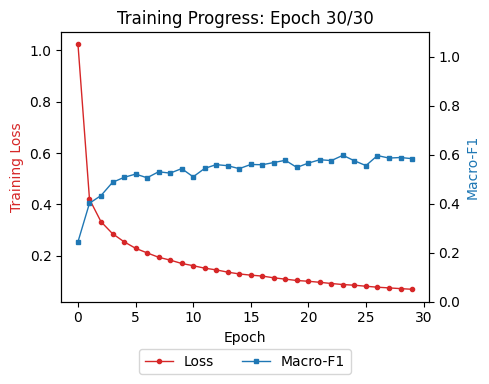

In [ ]:
BATCH_SIZE = 256
EPOCHS = 30
LR_HEAD = 5e-3
LR_TFM = 2e-5
MAX_WORDS = 30
MAX_SUBWORDS = 80
FINE = True

MODEL_PATH = "models/xlm-roberta-large"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = DEVICE.startswith("cuda")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_PATH)
num_tags = compute_num_tags(ds_train, fine_labels_enbl=FINE)
PAD_TAG = num_tags - 1

tfm_encoder = TransformerEncoder(tokenizer=tokenizer)

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}
train_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_train,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=True,
    **loader_args,
)

val_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_val,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=False,
    **loader_args,
)

model = XLMCRF(num_tags=num_tags, max_words=MAX_WORDS, device=DEVICE, model_path=MODEL_PATH).to(DEVICE)

# Freeze all then unfreeze last 2 layers + head/CRF
for p in model.transformer.parameters():
    p.requires_grad = False
k = 2
enc_layers = model.transformer.encoder.layer
for layer in enc_layers[-k:]:
    for p in layer.parameters():
        p.requires_grad = True

# Two LR groups
tf_params, head_params = [], []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("transformer."):
        tf_params.append(p)
    else:
        head_params.append(p)

optim = torch.optim.Adam([
    {"params": tf_params, "lr": LR_TFM},
    {"params": head_params, "lr": LR_HEAD},
])

train_losses, val_f1s = [], []
plot_handle = display(None, display_id=True)

# We store the best models to disk
old_f1 = 0
save_dir = "models/neural_crf_tfm"
METRICS_PATH = f"{save_dir}/crf_training_metrics.jsonl"
os.makedirs(save_dir, exist_ok=True)
best_model = 0

with open(METRICS_PATH, "w") as fjsonl:
    epoch_pbar = tqdm(range(EPOCHS), desc="Epoch", position=0)
    for epoch in epoch_pbar:
        model.train()
        model.transformer.train()

        total_loss = 0.0
        n_steps = 0

        pbar = tqdm(
            train_data_tfm,
            desc=f"Train {epoch + 1}/{EPOCHS}",
            leave=False,
            position=1,
        )

        for input_ids, attn, wids, tags, mask, _ in pbar:
            input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
            attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
            wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
            tags      = tags.to(DEVICE, non_blocking=PIN_MEMORY)
            mask      = mask.to(DEVICE, non_blocking=PIN_MEMORY)

            optim.zero_grad(set_to_none=True)

            loss = model(input_ids, attn, wids, tags, mask)
            loss.backward()

            optim.step()

            loss_item = float(loss.item())
            total_loss += loss_item
            n_steps += 1
            pbar.set_postfix(loss=f"{loss_item:.4f}")

        avg_loss = (total_loss / n_steps) if n_steps > 0 else float("nan")
        train_losses.append(float(avg_loss))

        # Eval
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
            for input_ids, attn, wids, tags, mask, _ in tqdm(
                val_data_tfm,
                desc=f"Eval {epoch + 1}/{EPOCHS}",
                leave=False,
                position=1,
            ):
                input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
                attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
                wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
                mask_t    = mask.to(DEVICE, non_blocking=PIN_MEMORY)

                pred_batch = model.decode(input_ids, attn, wids, mask_t)
                tags_batch = tags.tolist()
                mask_batch = mask.tolist()

                for g, p, mk in zip(tags_batch, pred_batch, mask_batch):
                    L = int(sum(mk))
                    g = g[:L]
                    p = p[:L]
                    g = [x for x in g if x != PAD_TAG]
                    p = [x for x in p if x != PAD_TAG]
                    gold_all.append(g)
                    pred_all.append(p)

        classes = get_active_span_classes(gold_all, pred_all)
        _, macro_f1, *_ = count_per_class_scores(gold_all, pred_all, classes)
        macro_f1 = float(macro_f1)
        val_f1s.append(macro_f1)

        if old_f1 < macro_f1:
            old_f1 = macro_f1
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            best_model = f"model_epoch_{epoch}.pt"

        # Visualize & log (same style as baseline)
        update_training_plot(train_losses, val_f1s, epoch, EPOCHS, plot_handle)

        metrics = {"epoch": epoch, "loss": float(avg_loss), "f1": macro_f1}
        fjsonl.write(json.dumps(metrics) + "\n")
        fjsonl.flush()

        epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}", f1=f"{macro_f1:.4f}")

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Test Evaluation
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Same as we applied for CRF only.
</p>

In [ ]:
# Execute test for clean test set using the best model
model.load_state_dict(torch.load(os.path.join(save_dir, best_model), weights_only=True))
test_model(model, ds_test, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.534 ± 0.0012; 95%-CI (0.531, 0.536)
Macro P  = 0.549 ± 0.0012; 95%-CI (0.547, 0.552)
Macro R  = 0.531 ± 0.0014; 95%-CI (0.528, 0.534)


In [ ]:
# Execute test for noisy test set
test_model(model, ds_test_noisy, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.479 ± 0.0022; 95%-CI (0.475, 0.484)
Macro P  = 0.497 ± 0.0023; 95%-CI (0.492, 0.501)
Macro R  = 0.475 ± 0.0026; 95%-CI (0.470, 0.480)


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Training XLM-R + CRF with LoRA
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We follow the same Transformer&ndash;CRF training setup as before, but replace unfreezing the last Transformer layers with LoRA adapters. Concretely, we freeze all XLM-R parameters and inject low-rank update matrices into the attention projections (<code style="font-size:12px;">query</code>, <code style="font-size:12px;">key</code>, <code style="font-size:12px;">value</code>) using <code style="font-size:12px;">r=16</code> and <code style="font-size:12px;">lora_alpha=32</code>. This way, only the LoRA parameters and the CRF head are trained, while the base Transformer weights remain fixed.
</p>

trainable params: 2,359,296 || all params: 561,200,128 || trainable%: 0.4204


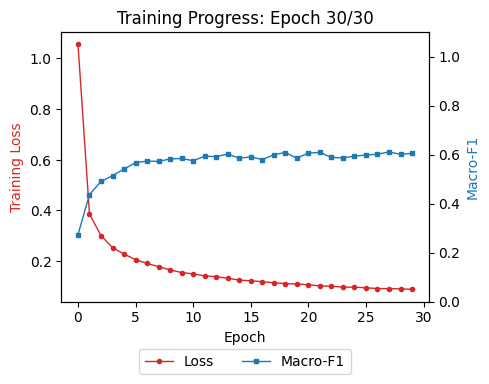

In [ ]:
BATCH_SIZE = 256
EPOCHS = 30
LR_HEAD = 5e-3
LR_TFM = 2e-5
MAX_WORDS = 30
MAX_SUBWORDS = 80
FINE = True

MODEL_PATH = "models/xlm-roberta-large"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = DEVICE.startswith("cuda")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_PATH)
num_tags = compute_num_tags(ds_train, fine_labels_enbl=FINE)
PAD_TAG = num_tags - 1

tfm_encoder = TransformerEncoder(tokenizer=tokenizer)

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}
train_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_train,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=True,
    **loader_args,
)

val_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_val,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=False,
    **loader_args,
)

model = XLMCRF(num_tags=num_tags, max_words=MAX_WORDS, device=DEVICE, model_path=MODEL_PATH).to(DEVICE)

# Freeze all transformer parameters
for p in model.transformer.parameters():
    p.requires_grad = False

# Apply low rank matricies to Q,K and V of MHA
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    task_type=TaskType.FEATURE_EXTRACTION,
    use_rslora=True,
)
model.transformer = get_peft_model(model.transformer, peft_config)
model.transformer.print_trainable_parameters()

# Two LR groups
tf_params, head_params = [], []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("transformer."):
        tf_params.append(p)
    else:
        head_params.append(p)

optim = torch.optim.Adam([
    {"params": tf_params, "lr": LR_TFM},
    {"params": head_params, "lr": LR_HEAD},
])

train_losses, val_f1s = [], []
plot_handle = display(None, display_id=True)

# We store the best models to disk
old_f1 = 0
save_dir = "models/neural_crf_tfm_lora"
METRICS_PATH = f"{save_dir}/crf_training_metrics.jsonl"
os.makedirs(save_dir, exist_ok=True)
best_model = 0

with open(METRICS_PATH, "w") as fjsonl:
    epoch_pbar = tqdm(range(EPOCHS), desc="Epoch", position=0)
    for epoch in epoch_pbar:
        model.train()
        model.transformer.train()

        total_loss = 0.0
        n_steps = 0

        pbar = tqdm(
            train_data_tfm,
            desc=f"Train {epoch + 1}/{EPOCHS}",
            leave=False,
            position=1,
        )

        for input_ids, attn, wids, tags, mask, _ in pbar:
            input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
            attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
            wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
            tags      = tags.to(DEVICE, non_blocking=PIN_MEMORY)
            mask      = mask.to(DEVICE, non_blocking=PIN_MEMORY)

            optim.zero_grad(set_to_none=True)

            loss = model(input_ids, attn, wids, tags, mask)
            loss.backward()

            optim.step()

            loss_item = float(loss.item())
            total_loss += loss_item
            n_steps += 1
            pbar.set_postfix(loss=f"{total_loss / n_steps:.4f}")

        avg_loss = (total_loss / n_steps) if n_steps > 0 else float("nan")
        train_losses.append(float(avg_loss))

        # Eval
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
            for input_ids, attn, wids, tags, mask, _ in tqdm(
                val_data_tfm,
                desc=f"Eval {epoch + 1}/{EPOCHS}",
                leave=False,
                position=1,
            ):
                input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
                attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
                wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
                mask_t    = mask.to(DEVICE, non_blocking=PIN_MEMORY)

                pred_batch = model.decode(input_ids, attn, wids, mask_t)
                tags_batch = tags.tolist()
                mask_batch = mask.tolist()

                for g, p, mk in zip(tags_batch, pred_batch, mask_batch):
                    L = int(sum(mk))
                    g = g[:L]
                    p = p[:L]
                    g = [x for x in g if x != PAD_TAG]
                    p = [x for x in p if x != PAD_TAG]
                    gold_all.append(g)
                    pred_all.append(p)

        classes = get_active_span_classes(gold_all, pred_all)
        _, macro_f1, *_ = count_per_class_scores(gold_all, pred_all, classes)
        macro_f1 = float(macro_f1)
        val_f1s.append(macro_f1)

        if old_f1 < macro_f1:
            old_f1 = macro_f1
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            best_model = f"model_epoch_{epoch}.pt"

        # Visualize & log (same style as baseline)
        update_training_plot(train_losses, val_f1s, epoch, EPOCHS, plot_handle)

        metrics = {"epoch": epoch, "loss": float(avg_loss), "f1": macro_f1}
        fjsonl.write(json.dumps(metrics) + "\n")
        fjsonl.flush()

        epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}", f1=f"{macro_f1:.4f}")

<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Test Evaluation
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  Same as we applied for CRF and TFM.
</p>

In [ ]:
# Execute test for clean test set using the best model
model.load_state_dict(torch.load(os.path.join(save_dir, best_model), weights_only=True))
test_model(model, ds_test, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.586 ± 0.0012; 95%-CI (0.583, 0.588)
Macro P  = 0.613 ± 0.0013; 95%-CI (0.610, 0.615)
Macro R  = 0.570 ± 0.0014; 95%-CI (0.567, 0.572)


In [ ]:
# Execute test for noisy test set
test_model(model, ds_test_noisy, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.538 ± 0.0022; 95%-CI (0.534, 0.542)
Macro P  = 0.568 ± 0.0025; 95%-CI (0.563, 0.573)
Macro R  = 0.522 ± 0.0024; 95%-CI (0.517, 0.526)


<h2 style="margin:0 0 4px 0; font-weight:500; font-size:18px;">
  Multi lingual Training
</h2>

<p style="margin:0 0 8px 0; font-size:13px; line-height:1.25;">
  We now repeat the LoRA training step with MULTI-Multilingual subset of the MultiCoNER II dataset.
</p>

In [ ]:
prep_multi = LoadMultiConer(
    dest_dir="multiconer2023",
    lang_subdir="MULTI-Multilingual",
)

splits_multi = prep_multi.load_splits()

# Train is taken from MULTI
ds_train_multi = splits_multi["train"]

print(f"Train has {len(ds_train_multi)} samples")

Train has 170824 samples


trainable params: 2,359,296 || all params: 561,200,128 || trainable%: 0.4204


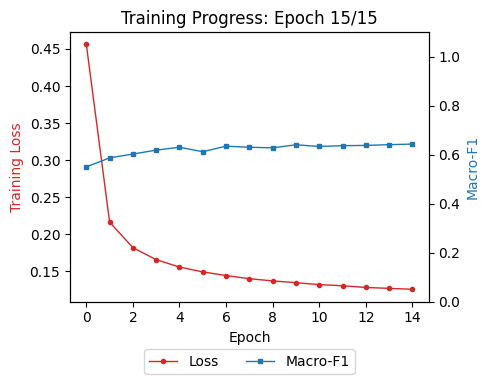

In [ ]:
BATCH_SIZE = 512
EPOCHS = 15
LR_HEAD = 5e-3
LR_TFM = 2e-5
MAX_WORDS = 30
MAX_SUBWORDS = 80
FINE = True

MODEL_PATH = "models/xlm-roberta-large"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = DEVICE.startswith("cuda")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_PATH)
num_tags = compute_num_tags(ds_train_multi, fine_labels_enbl=FINE)
PAD_TAG = num_tags - 1

tfm_encoder = TransformerEncoder(tokenizer=tokenizer)

loader_args = {"batch_size": BATCH_SIZE, "collate_fn": collate_multiconer}
train_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_train_multi,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=True,
    **loader_args,
)

val_data_tfm = DataLoader(
    MultiCoNERDataset(
        ds_val,
        max_seq_len=MAX_SUBWORDS,
        fine_labels_enbl=FINE,
        pad_tag=PAD_TAG,
        encoder=tfm_encoder,
        output_format="tfm_crf",
        max_word_len=MAX_WORDS,
    ),
    shuffle=False,
    **loader_args,
)

model = XLMCRF(num_tags=num_tags, max_words=MAX_WORDS, device=DEVICE, model_path=MODEL_PATH).to(DEVICE)

# Freeze all transformer parameters
for p in model.transformer.parameters():
    p.requires_grad = False

# Apply low rank matricies to Q,K and V of MHA
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    task_type=TaskType.FEATURE_EXTRACTION,
    use_rslora=True,
)
model.transformer = get_peft_model(model.transformer, peft_config)
model.transformer.print_trainable_parameters()

# Two LR groups
tf_params, head_params = [], []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("transformer."):
        tf_params.append(p)
    else:
        head_params.append(p)

optim = torch.optim.Adam([
    {"params": tf_params, "lr": LR_TFM},
    {"params": head_params, "lr": LR_HEAD},
])

train_losses, val_f1s = [], []
plot_handle = display(None, display_id=True)

# We store the best models to disk
old_f1 = 0
save_dir = "models/neural_crf_tfm_lora_multi_lang"
METRICS_PATH = f"{save_dir}/crf_training_metrics.jsonl"
os.makedirs(save_dir, exist_ok=True)
best_model = 0

with open(METRICS_PATH, "w") as fjsonl:
    epoch_pbar = tqdm(range(EPOCHS), desc="Epoch", position=0)
    for epoch in epoch_pbar:
        model.train()
        model.transformer.train()

        total_loss = 0.0
        n_steps = 0

        pbar = tqdm(
            train_data_tfm,
            desc=f"Train {epoch + 1}/{EPOCHS}",
            leave=False,
            position=1,
        )

        for input_ids, attn, wids, tags, mask, _ in pbar:
            input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
            attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
            wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
            tags      = tags.to(DEVICE, non_blocking=PIN_MEMORY)
            mask      = mask.to(DEVICE, non_blocking=PIN_MEMORY)

            optim.zero_grad(set_to_none=True)

            loss = model(input_ids, attn, wids, tags, mask)
            loss.backward()

            optim.step()

            loss_item = float(loss.item())
            total_loss += loss_item
            n_steps += 1
            pbar.set_postfix(loss=f"{total_loss / n_steps:.4f}")

        avg_loss = (total_loss / n_steps) if n_steps > 0 else float("nan")
        train_losses.append(float(avg_loss))

        # Eval
        model.eval()
        gold_all, pred_all = [], []
        with torch.no_grad():
            for input_ids, attn, wids, tags, mask, _ in tqdm(
                val_data_tfm,
                desc=f"Eval {epoch + 1}/{EPOCHS}",
                leave=False,
                position=1,
            ):
                input_ids = input_ids.to(DEVICE, non_blocking=PIN_MEMORY)
                attn      = attn.to(DEVICE, non_blocking=PIN_MEMORY)
                wids      = wids.to(DEVICE, non_blocking=PIN_MEMORY)
                mask_t    = mask.to(DEVICE, non_blocking=PIN_MEMORY)

                pred_batch = model.decode(input_ids, attn, wids, mask_t)
                tags_batch = tags.tolist()
                mask_batch = mask.tolist()

                for g, p, mk in zip(tags_batch, pred_batch, mask_batch):
                    L = int(sum(mk))
                    g = g[:L]
                    p = p[:L]
                    g = [x for x in g if x != PAD_TAG]
                    p = [x for x in p if x != PAD_TAG]
                    gold_all.append(g)
                    pred_all.append(p)

        classes = get_active_span_classes(gold_all, pred_all)
        _, macro_f1, *_ = count_per_class_scores(gold_all, pred_all, classes)
        macro_f1 = float(macro_f1)
        val_f1s.append(macro_f1)

        if old_f1 < macro_f1:
            old_f1 = macro_f1
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            best_model = f"model_epoch_{epoch}.pt"

        # Visualize & log (same style as baseline)
        update_training_plot(train_losses, val_f1s, epoch, EPOCHS, plot_handle)

        metrics = {"epoch": epoch, "loss": float(avg_loss), "f1": macro_f1}
        fjsonl.write(json.dumps(metrics) + "\n")
        fjsonl.flush()

        epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}", f1=f"{macro_f1:.4f}")

In [ ]:
# Execute test for clean test set using the best model
model.load_state_dict(torch.load(os.path.join(save_dir, best_model), weights_only=True))
test_model(model, ds_test, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.624 ± 0.0013; 95%-CI (0.621, 0.626)
Macro P  = 0.658 ± 0.0013; 95%-CI (0.656, 0.661)
Macro R  = 0.602 ± 0.0014; 95%-CI (0.599, 0.605)


In [ ]:
# Execute test for noisy test set
test_model(model, ds_test_noisy, BATCH_SIZE, "tfm_crf", tfm_encoder, MAX_WORDS, MAX_SUBWORDS, PAD_TAG, FINE)

Macro F1 = 0.585 ± 0.0023; 95%-CI (0.580, 0.589)
Macro P  = 0.621 ± 0.0024; 95%-CI (0.616, 0.626)
Macro R  = 0.563 ± 0.0025; 95%-CI (0.558, 0.567)
